### Détectection des faux billets avec Python

## 1. Preliminary

     *** Contexte ***

Identification des contrefaçons des billets en euros

Les billets d'euro ont des valeurs nominales de 5, 10, 20, 50, 100, 200 et 500 euros. 

In [323]:
!python -V


Python 3.9.13


## 1.1 Install

In [324]:
#!pip install --upgrade seaborn
#!pip install --upgrade pandas
#!pip install pandas --user
#!pip install --upgrade numexpr
#!pip install --upgrade bottleneck

#!pip install --upgrade matplotlib
#!pip install matplotlib --user

# 1.2 Importation

## 1.2.1 Importation des librairies

In [325]:
#builtin
import os

In [326]:

#data
import pandas as pd
import numpy as np

In [327]:

#visualisation 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import missingno as msno
from sklearn.model_selection import LearningCurveDisplay
%matplotlib inline

In [328]:
#machine learning
    #estimation
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
    #standardization
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


## 2.1 chargement des fichiers

In [329]:
input_folder = r"C:\Users\Nada\Desktop\OpenClassRooms\Projet 10\Data\0 Source"
# Read CSV train data file into DataFrame
train_df= pd.read_csv(os.path.join(input_folder, "billets.csv"), dtype=float, sep=';')
# Read CSV test data file into DataFrame
test_df = pd.read_csv(os.path.join(input_folder, "billets_production.csv"), sep=',')


## 2. Prétraitement des données

## 2.2 Exploration

In [330]:
#Affichage des 5 premieres lignes
train_df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1.0,171.81,104.86,104.95,4.52,2.89,112.83
1,1.0,171.46,103.36,103.66,3.77,2.99,113.09
2,1.0,172.69,104.48,103.50,4.40,2.94,113.16
3,1.0,171.36,103.91,103.94,3.62,3.01,113.51
4,1.0,171.73,104.28,103.46,4.04,3.48,112.54


In [331]:
print('Le nombre des itemes dans le DataFrame train_df est {}.'.format(train_df.shape[0]))

Le nombre des itemes dans le DataFrame train_df est 1500.


In [332]:
# preview test data
test_df.head()

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


test DataFrame contient 5 lignes sans valeurs manquantes.

In [333]:
print('Le nombre des itemes dans le DataFrame train_df est {}.'.format(test_df.shape[0]))

Le nombre des itemes dans le DataFrame train_df est 5.


Note: On ne voit pas la colonne 'is_genuine' (la target) dans le dataset test_df. Notre objectif est alors de prédire la target par differentes algorithmes de machine learning scomme la regression logistique.

In [334]:
#Affichage des 5 dernieres lignes
train_df.tail()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
1495,0.0,171.75,104.38,104.17,4.42,3.09,111.28
1496,0.0,172.19,104.63,104.44,5.27,3.37,110.97
1497,0.0,171.80,104.01,104.12,5.51,3.36,111.95
1498,0.0,172.06,104.28,104.06,5.17,3.46,112.25
1499,0.0,171.47,104.15,103.82,4.63,3.37,112.07


In [335]:
#Affichage de 5 lignes arbitrairement
train_df.sample(5)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
11,1.0,171.84,104.59,104.00,3.88,3.27,113.08
486,1.0,171.95,104.39,103.59,4.69,2.81,113.65
281,1.0,171.99,103.90,104.21,4.18,3.07,113.01
305,1.0,171.83,104.65,103.66,3.83,2.95,113.28
443,1.0,171.61,103.93,103.41,4.45,2.95,113.19


In [336]:
#Dimensions du DataFrame
train_df.shape

(1500, 7)

In [337]:
#Information sur les colonnes
train_df.dtypes

is_genuine      float64
diagonal        float64
height_left     float64
height_right    float64
margin_low      float64
margin_up       float64
length          float64
dtype: object

In [338]:
#Statistiques descriptives
train_df.describe().round(2)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.00,1500.00,1500.00,1500.00,1463.00,1500.00,1500.00
mean,0.67,171.96,104.03,103.92,4.49,3.15,112.68
std,0.47,0.31,0.30,0.33,0.66,0.23,0.87
min,0.00,171.04,103.14,102.82,2.98,2.27,109.49
25%,0.00,171.75,103.82,103.71,4.01,2.99,112.03
50%,1.00,171.96,104.04,103.92,4.31,3.14,112.96
75%,1.00,172.17,104.23,104.15,4.87,3.31,113.34
max,1.00,173.01,104.88,104.95,6.90,3.91,114.44


In [339]:
#Nombre des doublons dans le DataFrame
train_df.duplicated().sum()

0

In [340]:
#Nombre des doublons sans le target
train_df.drop(columns="is_genuine").duplicated().sum()

0

In [341]:
#Information sur les valeurs unique dans chaque colonne
train_df.nunique()

is_genuine        2
diagonal        159
height_left     155
height_right    170
margin_low      285
margin_up       123
length          336
dtype: int64

In [342]:
#Nombre des valeurs dans la target
train_df['is_genuine'].value_counts()

is_genuine
1.0    1000
0.0     500
Name: count, dtype: int64

In [343]:
#creation de la colonne target
train_df.rename(columns={'is_genuine':'target'}, inplace=True)

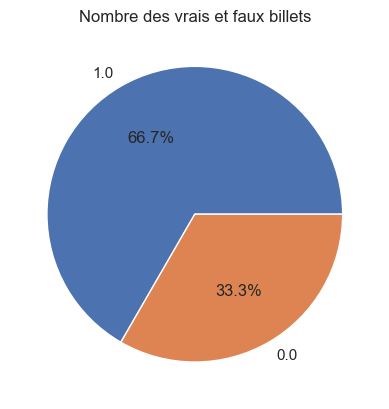

In [344]:
data=train_df['target'].value_counts()
labels=data.index
plt.pie(data, labels=labels, autopct='%1.1f%%')
plt.title('Nombre des vrais et faux billets')
plt.show()

1=Vrais
0=faux

## 2.3 Nettoyage des données

In [345]:
#Nombre des valeurs manquantes dans chaque colonne
train_df.isnull().sum()

target           0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

On a 37 valeurs manquantes dans la colonne margin_low

In [346]:
# Pourçentage des valeurs manquantes 
print('Percent of missing "margin_low" records is %.2f%%' %((train_df['margin_low'].isnull().sum()/train_df.shape[0])*100))

Percent of missing "margin_low" records is 2.47%


~2,5% des données dans la colonne margin_low est manquantes. -> voir la distribution de cette variable

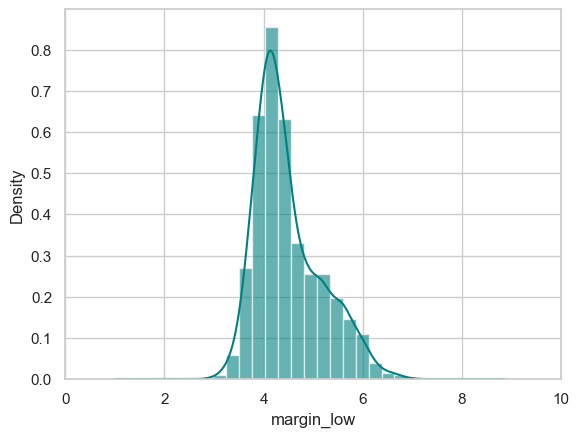

In [347]:
ax = train_df["margin_low"].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
train_df["margin_low"].plot(kind='density', color='teal')
ax.set(xlabel='margin_low')
plt.xlim(0,10)
plt.show()

la mediane de margin_low est entre 4 et 5 mm. On va essayer la regression lineaire pour l'imputation des valeurs manquantes.

### 2.3.1 Imputation des valeurs manquantes

On a un DataFrame qui contient X=6 (features)

## Imputation des valeurs manquantes

les valeurs manquantes sont de type numerique

*** 1. La methode regression lineaire de sklearn ***

In [348]:
#Creation d'une copy de notre DataFrame
df_reg=train_df.copy()

In [349]:
# Séparer les données en deux ensembles : avec et sans valeurs manquantes

test= df_reg[df_reg['margin_low'].isna()] #DataFrame qui contient que des valeurs manquantes dans la colonne margin_low

train = df_reg[~df_reg['margin_low'].isna()] #dataframe sans valeurs manquantes

In [350]:
test.shape

(37, 7)

In [351]:
train.shape

(1463, 7)

In [352]:
# Diviser les données en variables explicatives (X) et la variable cible (y)
#les variables explicative (X)
X_train = train.drop(columns=['margin_low']) 
X_train

,target,diagonal,height_left,height_right,margin_up,length
0,1.0,171.81,104.86,104.95,2.89,112.83
1,1.0,171.46,103.36,103.66,2.99,113.09
2,1.0,172.69,104.48,103.50,2.94,113.16
3,1.0,171.36,103.91,103.94,3.01,113.51
4,1.0,171.73,104.28,103.46,3.48,112.54
...,...,...,...,...,...,...
1495,0.0,171.75,104.38,104.17,3.09,111.28
1496,0.0,172.19,104.63,104.44,3.37,110.97
1497,0.0,171.80,104.01,104.12,3.36,111.95
1498,0.0,172.06,104.28,104.06,3.46,112.25


In [353]:
# Diviser les données en variables explicatives (X) et la variable cible (y)
#la variable cible (y) (target)
y_train= train['margin_low']
y_train.shape

(1463,)

In [354]:
## Model
# Créer et entraîner le modèle de régression linéaire
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [355]:
#creation de la variable X_test
X_test = test.drop(columns=['margin_low'])

In [356]:
# Prédire les valeurs manquantes
y_predicted = model.predict(X_test)

In [357]:
y_predicted.shape

(37,)

In [358]:
# Remplacer les valeurs manquantes par les valeurs prédites
df_reg.loc[df_reg['margin_low'].isna(), 'margin_low'] = y_predicted

In [359]:
y_predicted

array([4.06495361, 4.11199026, 4.13400328, 3.99357074, 4.1403993 ,
       4.09428392, 4.07412432, 4.12538999, 4.0807278 , 4.07363322,
       4.11897255, 4.18037978, 4.13648423, 4.05106842, 4.17837685,
       4.22555104, 4.11586845, 4.10284101, 4.08184346, 4.09276238,
       4.11250192, 4.15717623, 4.16028787, 4.12193808, 4.12353555,
       4.19842271, 4.10962313, 4.09696025, 4.13384101, 5.25968515,
       5.264817  , 5.28251853, 5.30206887, 5.20035843, 5.1754678 ,
       5.17345045, 5.24675055])

In [360]:
y_predicted.shape

(37,)

In [361]:
#Verification
df_reg.isnull().sum()

target          0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

In [362]:
# preview adjusted train data
df_reg.head()

,target,diagonal,height_left,height_right,margin_low,margin_up,length
0,1.0,171.81,104.86,104.95,4.52,2.89,112.83
1,1.0,171.46,103.36,103.66,3.77,2.99,113.09
2,1.0,172.69,104.48,103.50,4.40,2.94,113.16
3,1.0,171.36,103.91,103.94,3.62,3.01,113.51
4,1.0,171.73,104.28,103.46,4.04,3.48,112.54


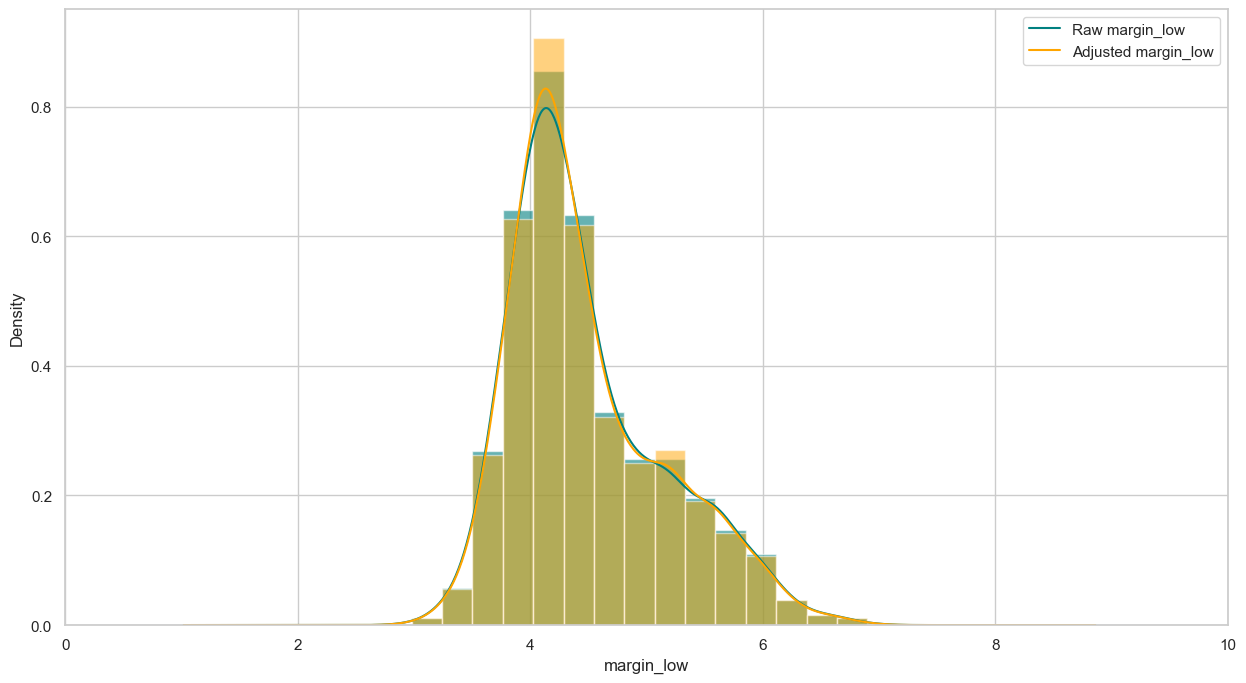

In [363]:
#Verification avec visualisation
plt.figure(figsize=(15,8))
ax = train_df["margin_low"].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
train_df["margin_low"].plot(kind='density', color='teal')
ax = df_reg["margin_low"].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.5)
df_reg["margin_low"].plot(kind='density', color='orange')
ax.legend(['Raw margin_low', 'Adjusted margin_low'])
ax.set(xlabel='margin_low')
plt.xlim(0,10)
plt.show()

2. La méthode de régression linéaire de Statsmodels

In [364]:
# Creation d'une copy de DataFrame
df_stat=train_df.copy()

In [365]:
# Séparation des données en deux ensembles : un ensemble avec des valeurs manquantes et un ensemble sans valeurs manquantes
data_missing = df_stat[df_stat['margin_low'].isnull()]
data_not_missing = df_stat[~df_stat['margin_low'].isnull()]

In [366]:

X = data_not_missing.drop(['margin_low'], axis=1)
X.head()

,target,diagonal,height_left,height_right,margin_up,length
0,1.0,171.81,104.86,104.95,2.89,112.83
1,1.0,171.46,103.36,103.66,2.99,113.09
2,1.0,172.69,104.48,103.50,2.94,113.16
3,1.0,171.36,103.91,103.94,3.01,113.51
4,1.0,171.73,104.28,103.46,3.48,112.54


In [367]:
y = data_not_missing['margin_low']
y.head()

0    4.52
1    3.77
2    4.40
3    3.62
4    4.04
Name: margin_low, dtype: float64

*** Modele***

In [368]:
model = sm.OLS(y, X).fit()

In [369]:

predicted_values = model.predict(data_missing.drop(['margin_low'], axis=1))

In [370]:

df_stat.loc[df_stat['margin_low'].isnull(), 'margin_low'] = predicted_values

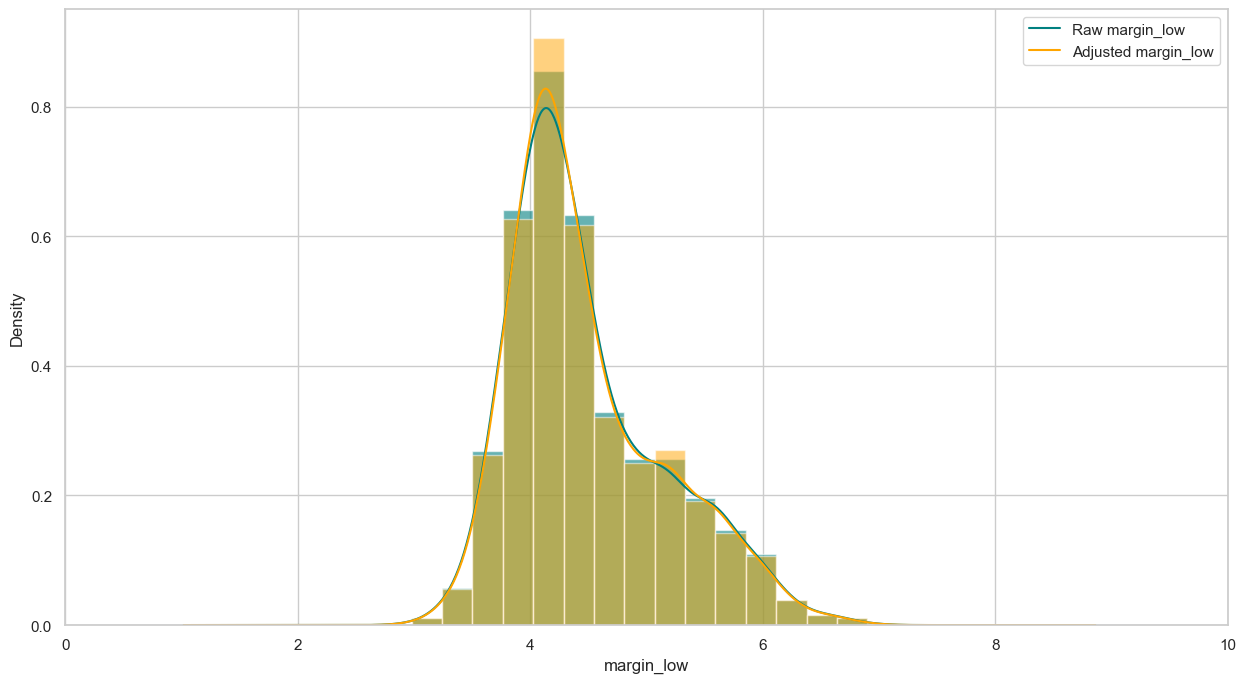

In [371]:
#Verification avec visualisation
plt.figure(figsize=(15,8))
ax = train_df["margin_low"].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
train_df["margin_low"].plot(kind='density', color='teal')
ax = df_stat["margin_low"].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.5)
df_stat["margin_low"].plot(kind='density', color='orange')
ax.legend(['Raw margin_low', 'Adjusted margin_low'])
ax.set(xlabel='margin_low')
plt.xlim(0,10)
plt.show()

In [372]:
# Convertir les colonnes en ensembles
ensemble_colonne_df1 = set(df_reg['margin_low'])
ensemble_colonne_df2 = set(df_stat['margin_low'])

# Trouver la différence entre les ensembles
difference = ensemble_colonne_df1 - ensemble_colonne_df2
len(difference)



37

***Exploration des données***

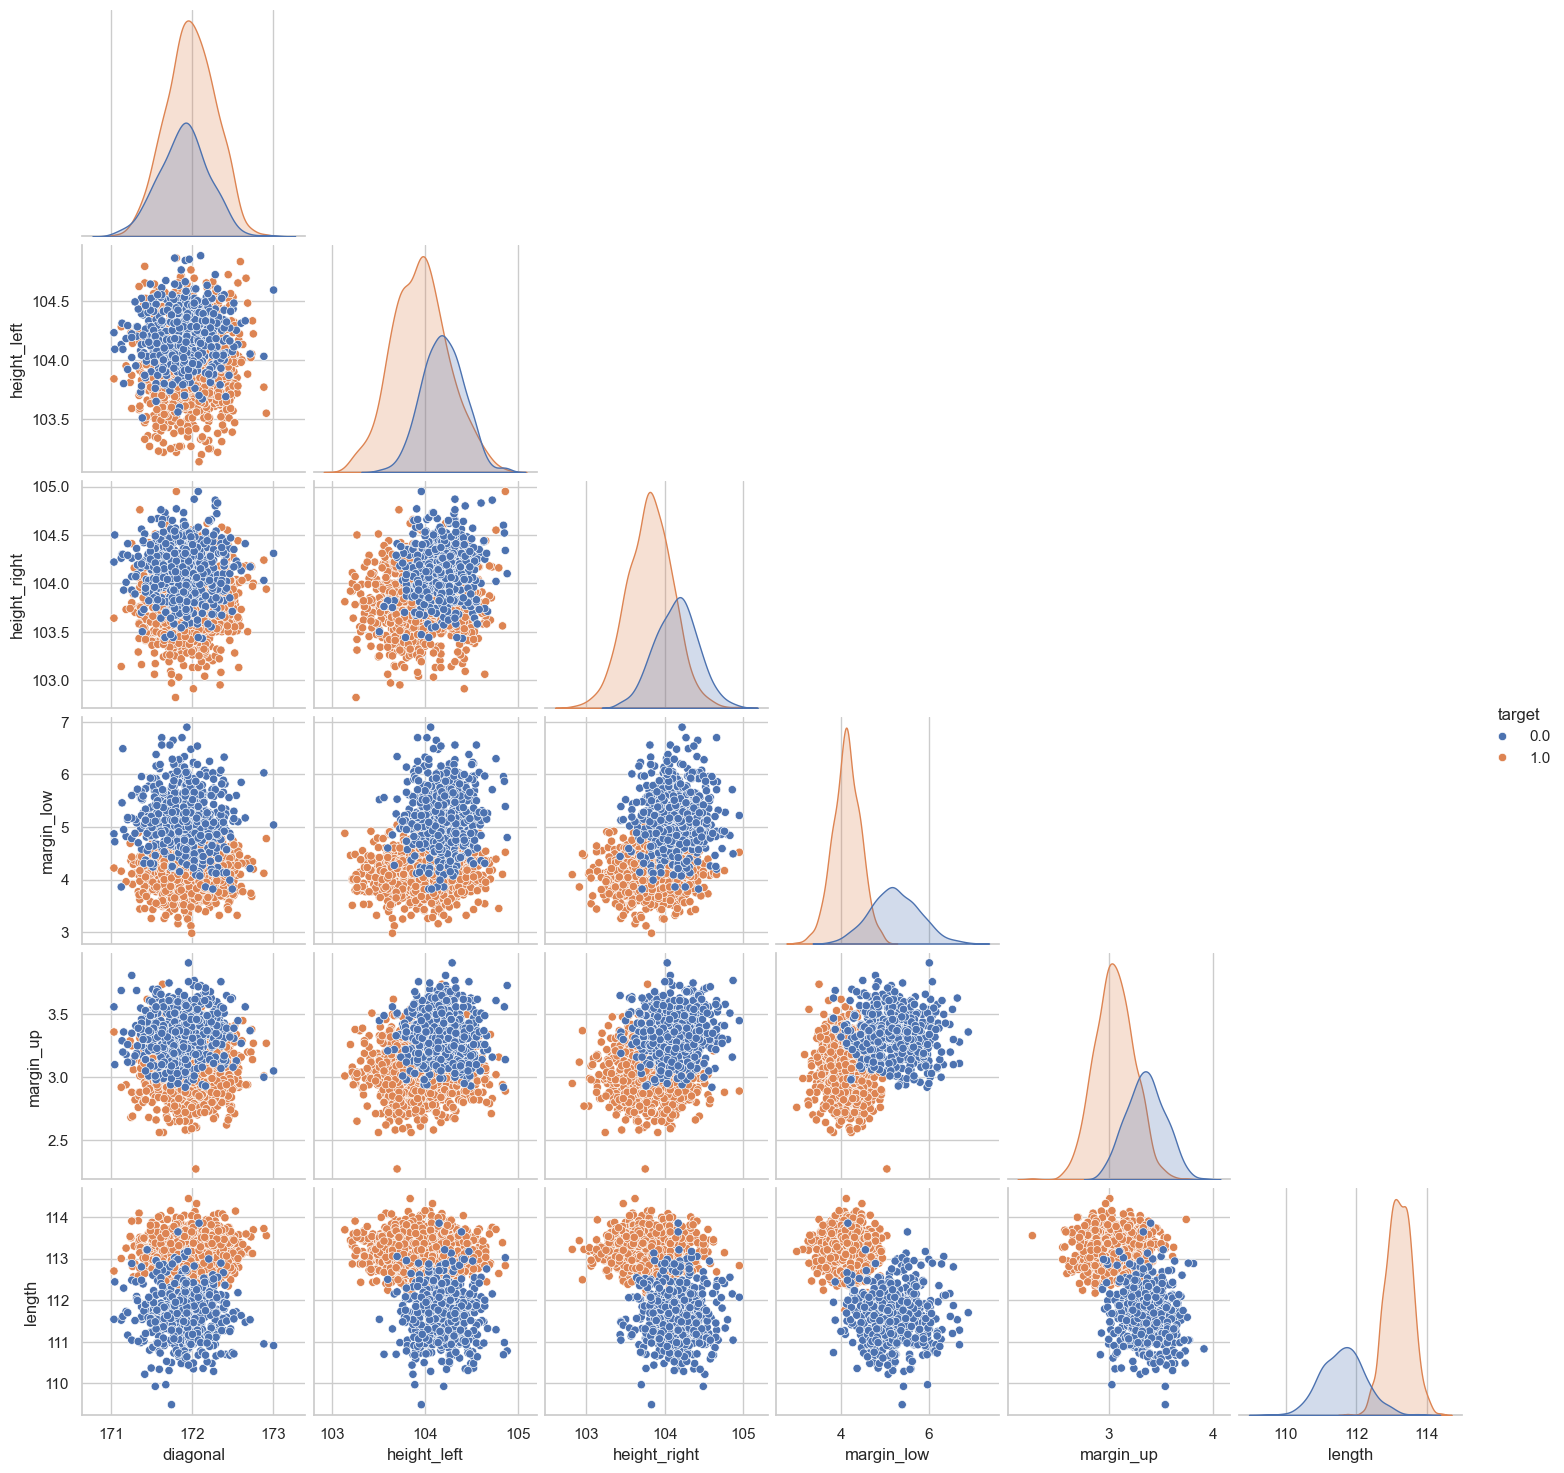

In [373]:
sns.pairplot(df_reg, hue='target', corner=True)
plt.show()

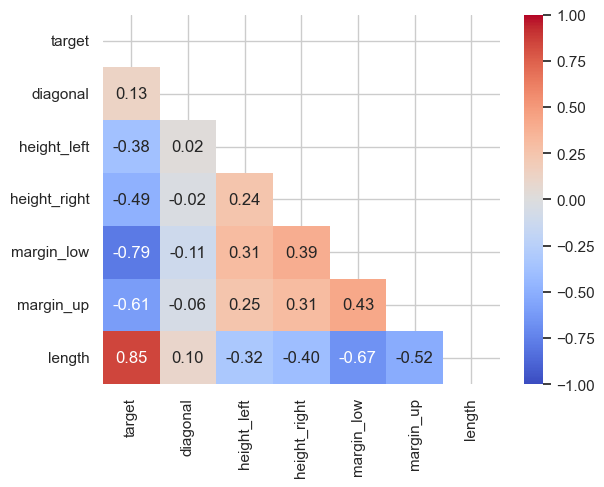

In [374]:
correlation_matrix = df_reg.corr()
masque=np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", mask=masque, vmin=-1, vmax=1)
plt.show()

la target est tres correlée avec la longeur des billets

## 2.3.2 Detection des outliers

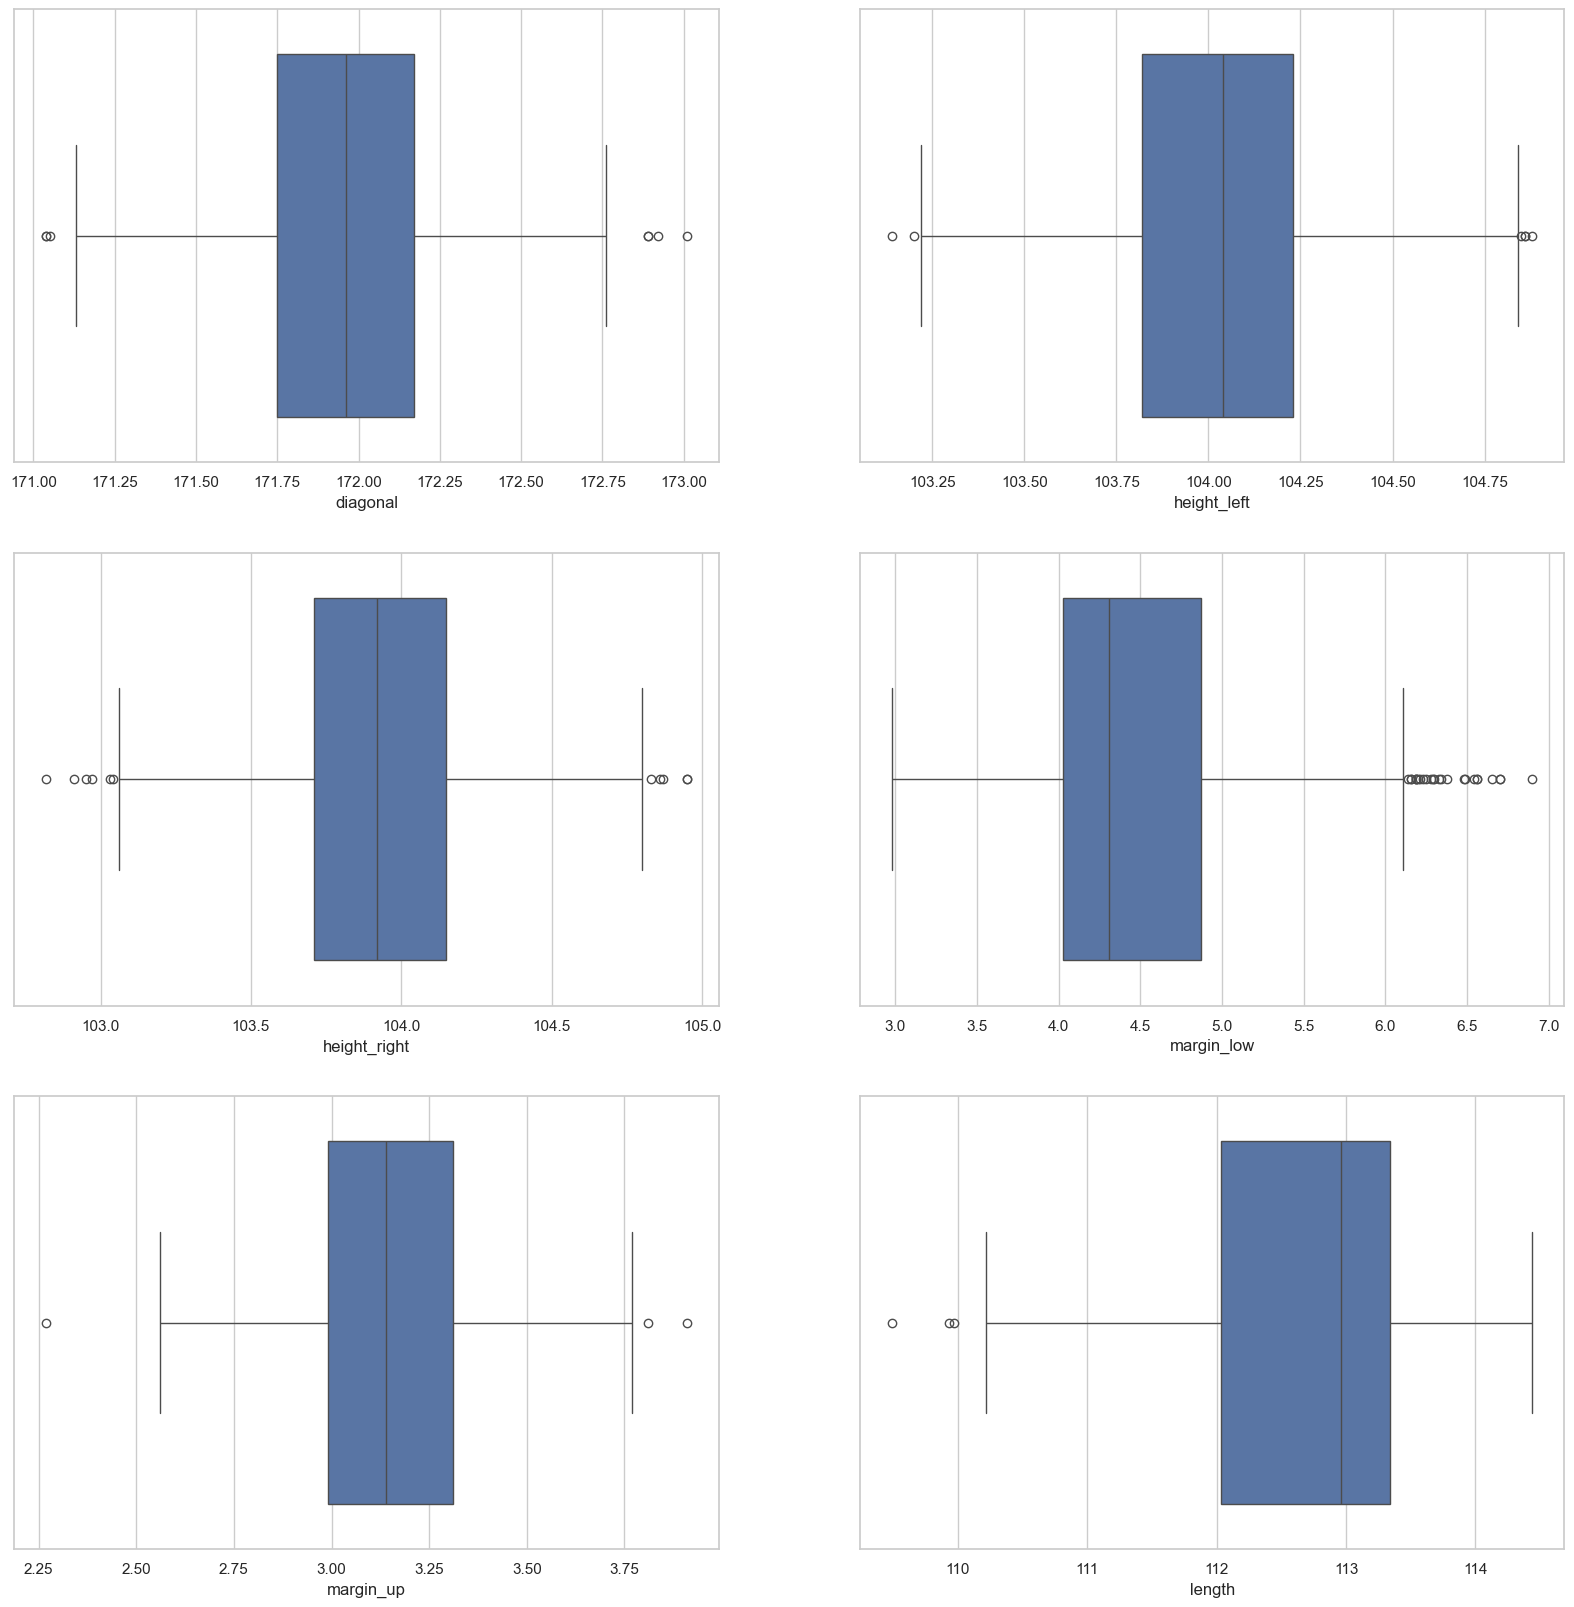

In [375]:
plt.figure(figsize=(20, 20))
sns.set_theme(style="whitegrid")

plt.subplot(321)
sns.boxplot(data=df_reg, x='diagonal')

plt.subplot(322)
sns.boxplot(data=df_reg, x='height_left')

plt.subplot(323)
sns.boxplot(data=df_reg, x='height_right')

plt.subplot(324)
sns.boxplot(data=df_reg, x='margin_low')

plt.subplot(325)
sns.boxplot(data=df_reg, x='margin_up')

plt.subplot(326)
sns.boxplot(data=df_reg, x='length')

plt.show()


Les boxplots montrent des outliers dans plusieurs features. Ceci peut indiquer que ces outliers pourraient être associés aux faux billets qui se distinguent par leurs dimensions non conformes

## 2.3.1.1 Data mining

## 2.4 Preparation des données

## 2.4.1. Standardization 

In [399]:
df_reg

,target,diagonal,height_left,height_right,margin_low,margin_up,length
0,1.0,171.81,104.86,104.95,4.52,2.89,112.83
1,1.0,171.46,103.36,103.66,3.77,2.99,113.09
2,1.0,172.69,104.48,103.50,4.40,2.94,113.16
3,1.0,171.36,103.91,103.94,3.62,3.01,113.51
4,1.0,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
1495,0.0,171.75,104.38,104.17,4.42,3.09,111.28
1496,0.0,172.19,104.63,104.44,5.27,3.37,110.97
1497,0.0,171.80,104.01,104.12,5.51,3.36,111.95
1498,0.0,172.06,104.28,104.06,5.17,3.46,112.25


In [400]:
X=df_reg.drop(columns=['target'])# (features) sans la target
y=df_reg.target

In [378]:
# Création d'une instance de StandardScaler
scaler = StandardScaler()
# Adapter le scaler aux données
scaler.fit(X)

StandardScaler()

In [379]:
# Standardiser les données
df_scaled = scaler.transform(X)
df_scaled[:5]

array([[-0.48653957,  2.77412327,  3.16324041,  0.0563237 , -1.128325  ,
         0.17365114],
       [-1.63372936, -2.23653528, -0.79966777, -1.08059227, -0.69679916,
         0.47166629],
       [ 2.3978233 ,  1.50475644, -1.29119126, -0.12558286, -0.91256208,
         0.55190114],
       [-1.96149786, -0.39929381,  0.06049835, -1.30797546, -0.61049399,
         0.95307539],
       [-0.74875438,  0.83666863, -1.41407214, -0.67130252,  1.41767746,
        -0.15875038]])

## A. Classifieur "naïf"

2.4.1 Creation de X & y

In [401]:
X= df_reg.drop(columns='target')  # (features) sans la target
y=df_reg.target # la target

In [402]:
X.head()

,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.81,104.86,104.95,4.52,2.89,112.83
1,171.46,103.36,103.66,3.77,2.99,113.09
2,172.69,104.48,103.50,4.40,2.94,113.16
3,171.36,103.91,103.94,3.62,3.01,113.51
4,171.73,104.28,103.46,4.04,3.48,112.54


In [403]:
y.head()

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: target, dtype: float64

2.4.2 Test Train split

In [404]:
from sklearn.model_selection import train_test_split

In [405]:
train_X, test_X, train_y, test_y= train_test_split(X, y, test_size=0.3, random_state=42)

In [385]:
print(f"Le DataFrame train_X est de la forme {train_X.shape} et train_y est de la forme {train_y.shape}.")

Le DataFrame train_X est de la forme (1050, 6) et train_y est de la forme (1050,).


In [386]:
print(f"Le DataFrame train_X est de la forme {test_X.shape} et train_y est de la forme {test_y.shape}.")

Le DataFrame train_X est de la forme (450, 6) et train_y est de la forme (450,).


2.5 Modelisation

2.5.1 Dummy clussifier

In [387]:
estimator= DummyClassifier(strategy="most_frequent")
estimator.fit(train_X, train_y)

DummyClassifier(strategy='most_frequent')

In [388]:
y_pred = estimator.predict(test_X)
y_pred

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [389]:
pd.Series(y_pred).value_counts()

1.0    450
Name: count, dtype: int64

In [390]:
test_y.value_counts(normalize=True)

target
1.0    0.642222
0.0    0.357778
Name: proportion, dtype: float64

In [391]:
test_y.values

array([0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0.,
       1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1.,
       1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1.,
       0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1.,
       1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1.,
       0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1.,
       1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1.,
       1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0.,
       1., 1., 1., 1., 1.

In [392]:
train_y

485     1.0
527     1.0
199     1.0
889     1.0
844     1.0
       ... 
1130    0.0
1294    0.0
860     1.0
1459    0.0
1126    0.0
Name: target, Length: 1050, dtype: float64

In [393]:
train_X

,diagonal,height_left,height_right,margin_low,margin_up,length
485,171.83,104.29,103.58,4.000000,3.32,113.21
527,171.92,103.79,103.34,3.840000,2.80,113.00
199,171.90,104.42,104.02,4.380000,3.10,112.87
889,172.31,103.94,103.89,4.000000,3.20,113.80
844,171.62,104.14,104.49,4.157176,2.99,113.35
...,...,...,...,...,...,...
1130,171.56,104.29,104.19,5.230000,3.63,112.94
1294,172.40,104.27,104.18,4.920000,3.17,111.79
860,171.38,103.83,103.99,4.440000,3.12,113.48
1459,171.78,104.31,103.82,6.190000,3.25,111.14


In [394]:
tr_score= estimator.score(train_X, train_y)
te_score= estimator.score(test_X, test_y)
print(f"le score de train est {tr_score}, et de test est {te_score}")

le score de train est 0.6771428571428572, et de test est 0.6422222222222222


In [395]:
y_pred = estimator.predict(test_X)
y_pred

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [396]:
test_y.values

array([0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0.,
       1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1.,
       1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1.,
       0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1.,
       1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1.,
       0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1.,
       1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1.,
       1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0.,
       1., 1., 1., 1., 1.

In [397]:
1 - abs(y_pred - test_y.values).mean()

0.6422222222222222

In [398]:
plot_learning_curve(estimator = estimator,
                    title     = "Learning Curves (Dummy clusters)",
                    X         = X,
                    y         = y,
                    ylim      = (0.5, 1.1),
                    cv        = StratifiedKFold(),
                    scoring   = 'accuracy',     
                    obj_line  = 0.85,    
                    n_jobs    = -1)  
plt.show()


NameError: name 'plot_learning_curve' is not defined